## Astral chiral point-line 3-configurations.



<img src="astral_5_2_2_1.png" width=600 height = 300>



In this notebook we will focus on astral 3-configurations. We will denote them
as $\cal A(m,j,k,t)$. The configuration $\cal A(5,2,2,1)$ is shown. It is saved in the file
astral_5_2_2_1.pdf. (It as been manually translated into astral_5_2_2_1.png). In general, there are two configurations for each set of parameters. The other one is stored as astral_5_2_2_1'.pdf.

See the explanation in several papers:

* **Chiral Astral Realizations of Cyclic 3-configurations** by Berman, DeOrsey, Faudree, Pisanski and Žitnik, *Discrete and Computational Geometry* (2021)
* **Geometric constructions for 3-configurations with non-trivial geometric symmetry**, by Berman, *Electronic Journal of Combinatorics*, (2013)
* **Highly Incident Configurations with Chiral Symmetry** by Berman and Faudree, *Discrete and Computatoional Geometry* (2013)


### Version of August 19, 2022
### by Tomaž Pisanski

### Start with configuration drawing programs

In [ ]:
from functools import reduce
import numpy as np
from itertools import permutations
from sympy import primefactors
#os.mkdir("experiments")
#
# Currently, all drawings are stored in a hardwired folder "experiments".
#
# You may uncomment the following line and then store the drawings in a different directory,
#e.g. "figures"
#
folder = "figures"
#os.mkdir(folder)

###########################
#
###########################
tex_header = r'''\documentclass[border=2mm]{standalone}
\usepackage{tikz}
\begin{document}
\begin{tikzpicture}[fill=blue,line width=1pt,fill opacity=0.9,scale=0.05]
\tikzstyle{every path}=[draw, thick]
\tikzstyle{every node}=[draw, circle, fill=red, inner sep=1.0pt]
'''

tex_footer =  r'''\end{tikzpicture}
\end{document}'''


def draw_cfg_latex(vts,lns,fig_name,folder = ''):
    f = open(folder + fig_name + '.tex', 'w')
    ret = tex_header
    for v, coord in vts.items():
        coord = float(coord[0]), float(coord[1])
        ret += r'\coordinate (v_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(v, coord[0], coord[1]) + '\n'
    for ll, (coord1,coord2) in lns.items():
        crd1 = float(coord1[0]), float(coord1[1])
        crd2 = float(coord2[0]), float(coord2[1])
        ret += r'\coordinate (u_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(ll, crd1[0], crd1[1]) + '\n'
        ret += r'\coordinate (w_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(ll, crd2[0], crd2[1]) + '\n'
    enu = {}
    for li in lns:
        u,v = lns[li]
        ret += r'\path (u_{0}) -- (w_{1});'.format(li, li) + '\n'
    for v, coord in vts.items():
        coord = float(coord[0]), float(coord[1])
        ret += r'\node (v_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(v, coord[0], coord[1]) + '\n'
    ret += tex_footer
    f.write(ret)
    f.close()
    
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=True, tangent_tol=1e-9):
    """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.

    :param circle_center: The (x, y) location of the circle center
    :param circle_radius: The radius of the circle
    :param pt1: The (x, y) location of the first point of the segment
    :param pt2: The (x, y) location of the second point of the segment
    :param full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
    :param tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
    :return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

    Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
    (from StackOverflow)
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr = (dx ** 2 + dy ** 2)**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        return []
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def dist(pta,ptb):
    """Euclidean distance between two point in the plane."""
    xa = pta[0]
    ya = pta[1]
    xb = ptb[0]
    yb = ptb[1]
    res = sqrt(float((xa-xb)*(xa-xb) + (ya-yb)*(ya-yb)))
    return res

def envelopping_circle(vts,lns,eps=0.1):
    cx = 0
    cy = 0
    for p in vts:
        (vx,vy) = vts[p]
        cx += float(vx)
        cy += float(vy)
    n = len(vts)
    cx = cx/float(n)
    cy = cy/float(n)
    cen = (cx,cy)
    rmax = 0
    for p in vts:
        rr = dist(cen,vts[p])
        if rr > rmax:
            rmax = rr
    radius = rmax*(1+eps)
    return cen,radius


def prepare_for_drawing(vts,lns,eps=0.2,dt="N"):
    """Prepare for drawing lines, depending on the type dt. 
    lns are given as pair of abstract points. nlns are computed as pair of coordinates.
    dt ... 'N' use points coordinates
       ... 'L' extend each line segment by eps.
       ... 'C' extend each line to its intersection with the encompassing circle. """
    nlns = {}
    if dt == "C": #extend to circle
        cx = 0
        cy = 0
        for p in vts:
            (vx,vy) = vts[p]
            cx += float(vx)
            cy += float(vy)
        n = len(vts)
        cx = cx/float(n)
        cy = cy/float(n)
        cen = (cx,cy)
        rmax = 0
        for p in vts:
            rr = dist(cen,vts[p])
            if rr > rmax:
                rmax = rr
        radius = rmax*(1+eps) # circle (cen, radius)  contains all configuration points.
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            res = circle_line_segment_intersection(cen, radius, vts[p], vts[q], full_line=True, tangent_tol=1e-9)
            ((xxp,yyp),(xxq,yyq)) = res
            nlns[k] = res
    elif dt == "L":
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            xxp = xp + eps*(xp-xq)
            xxq = xq + eps*(xq-xp)
            yyp = yp + eps*(yp-yq)
            yyq = yq + eps*(yq-yp)
            res = ((xxp,yyp),(xxq,yyq))
            nlns[k] = res
    else:    #dt = "N"
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            res = ((xp,yp),(xq,yq))
            nlns[k] = res
    return vts,nlns

def scale_points(vts,R = 100):
    """Scale point coordinates. Useful for ensuring approximately the same size
    points."""
    Rmax = 0
    for v in vts:
        (x,y) = vts[v]
        if abs(x) > Rmax:
            Rmax = abs(x)
        if abs(y) > Rmax:
            Rmax = abs(y)
    nvts = {}
    for v in vts:
        (x,y) = vts[v]
        nx = x*R/Rmax
        ny = y*R/Rmax
        nvts[v] = (nx,ny)
    return nvts

def reduce_points(vts,lns):
    """On each line keep only extreme points"""
    nlns = {}
    for ll in lns:
        pts = lns[ll]
        dmax = 0
        pmax = 0
        qmax = 0
        for p in pts:
            (xp,yp) = vts[p]
            for q in pts:
                if q <= p:
                    continue
                (xq,yq) = vts[q]
                d = sqrt((xp-xq)**2 + (yp-yq)**2)
                if d > dmax:
                    dmax = d
                    pmax = p
                    qmax = q
        nlns[ll] = (pmax,qmax)
    return (vts,nlns)

def plot_configuration(uts,lns,eps = 0.2,dt="N",where="S",fname = None,r=3,cline="black",cpoint="red",th=0.2):
    """plot configuration vts,lns, depending on type:
    dt ... 'N' use points coordinates
       ... 'L' extend each line segment by eps.
       ... 'C' extend each line to its intersection with the encompassing circle. 
    where ... 'S' - screen  (ignor fname)
          ... 'P' - as pdf on file fname.pdf
          ... 'T  - as tizk on file fname.tex '"""
    vts = scale_points(uts)
    pts,rlns = reduce_points(vts,lns)
    pts,nlns = prepare_for_drawing(pts,rlns,eps,dt)
    if where == "T": # draw using tikz on a .tex file
        draw_cfg_latex(pts,nlns,fname)
        return
    plt = Graphics()
    for k in nlns:
        ((xp,yp),(xq,yq)) = nlns[k]
        plt += line(((xp,yp),(xq,yq)),color = cline,thickness=th)
    for m in pts:
        (x,y) = pts[m]
        plt += circle((x,y),r,color = cline)
        plt += circle((x,y),r-1,color = cpoint,fill=True)
    if where == "S":
        plt.show(axes=False)
        plt.axes(False)
        return plt
    elif where == "P": #save pdf
        plt.save(fname+".pdf",axes=False)
        
    

### End of configuration drawing programs

In [ ]:
def Levi_graph_astral_3(m,j,k,t):
    volts = [(0,1,0),(0,1,j),(0,2,0),(3,2,0),(3,2,k),(3,1,t)]
    gr = cyclic_cover(m,volts)
    return gr 


### Configuration $\cal A(m,j,k,t)$

This configuration is given by its reduced Levi graph shown here but formally defined above.
Its cyclic cover is the Levi graph.

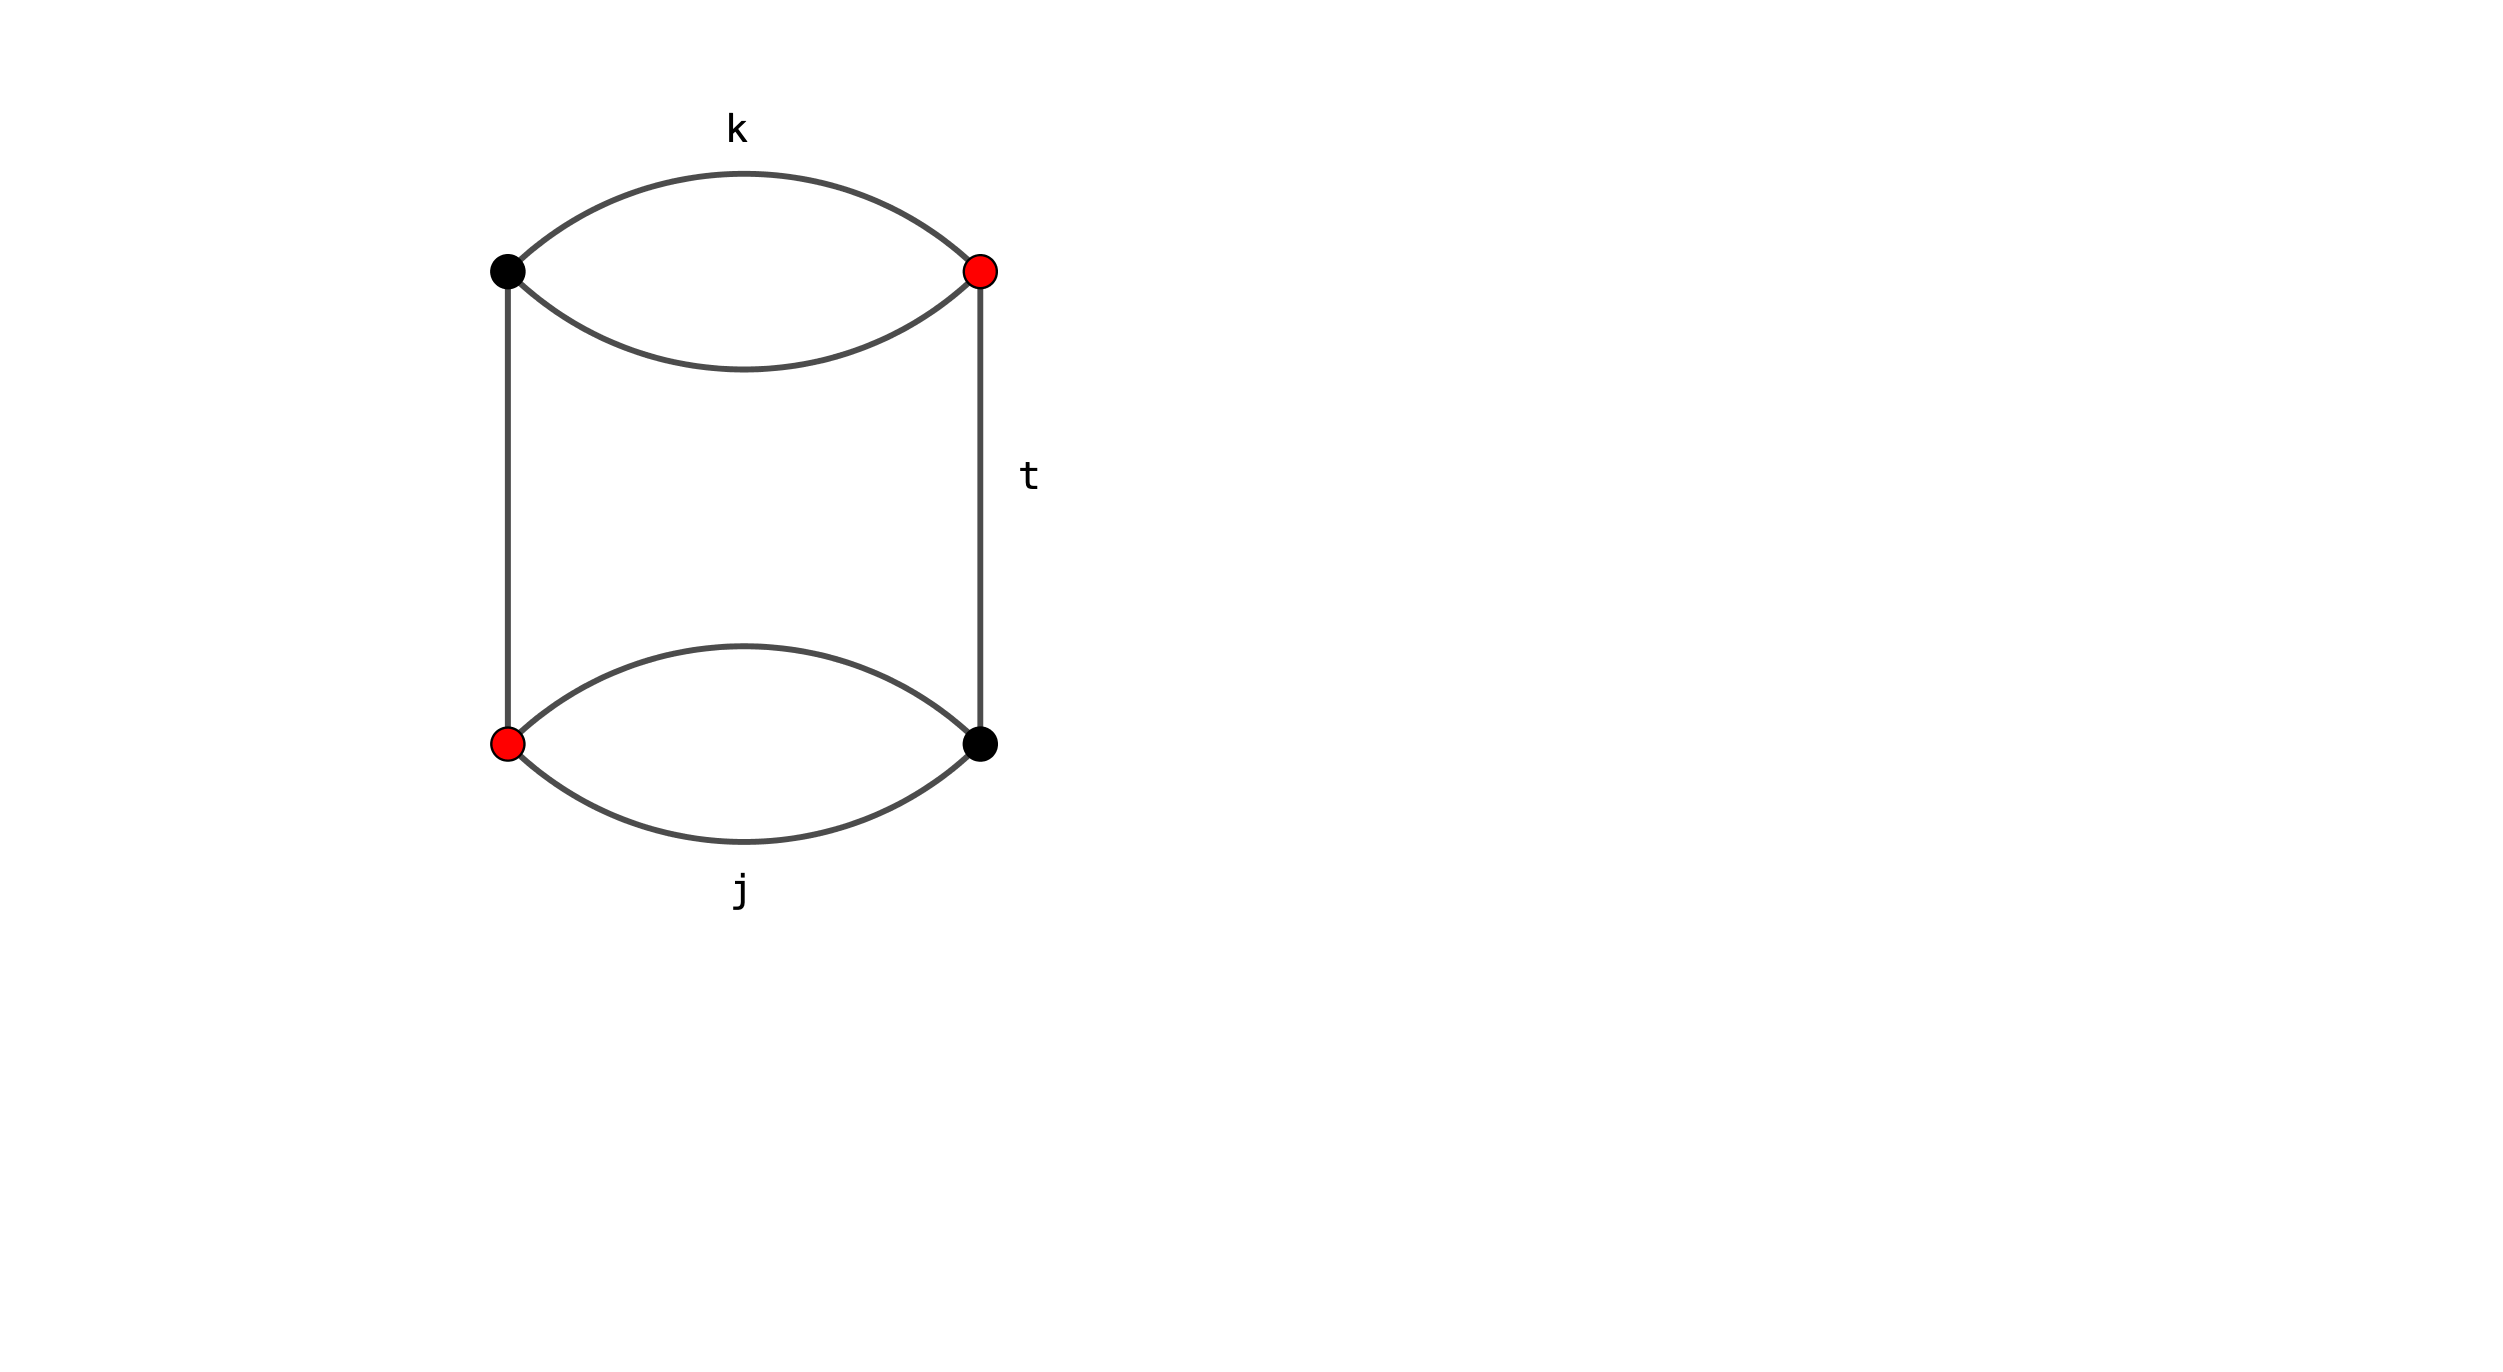

Program for computing cyclic cover over a voltage graph is given below.

In [ ]:
def cyclic_cover(n,volts,base=None):
    """Each base vertex is given by a radius and offset angle. Each voltage is given by triple, (from,to,i)"""
    if base == None:
        voltgr = DiGraph(volts,multiedges=True)
        basevts = voltgr.vertices()
        R = 10
        k = len(basevts)
        base=[(R*(i+1),0) for i in range(k)]
    verts = {}
    for j in range(len(base)):
        R = base[j][0]
        a = base[j][1]*pi/180
        for i in range(n):
            verts[n*j+i] = (R*cos(a+2*pi*i/n), R*sin(a+2*pi*i/n))
    eds = []
    for (frm,t,i) in volts:
        for j in range(n):
            eds += [[n*frm+j,n*t+(i+j)%n]]
#    print(eds)
    gr = Graph(eds,multiedges=True,pos=verts)
    return gr


The following code checks some properties of a Levi graph (bipartite graph).

-- Self-duality (= existence of an automorphism interchanging the two partite sets of vertices.) All astral cfgs are self-dual.

-- Vertex-transitivity (= configuration is self-dual, point- and line-transitive.

-- Edge-transitiviy (= configuration is at least weakly flag-transitive)

-- Arc-transitivity (= configuration is self-dual, point- and line-transitive and flag-transitive)

-- Connectedness

-- Girth

-- Order of the full automorphism group

-- Number of orbits on the elements of configuration. (Either 1 or 2 orbits for astral)

In [ ]:
def is_self_dual(gr):
    assert gr.is_connected()
    gru = gr.automorphism_group()
    verts = gr.vertices()
    v = verts[0]
    neigh = gr.neighbors(v)
    (a,b) = gr.bipartite_sets()
    if v in b:
        a,b = b,a
    orbv = set(gru.orbit(v))
    inter = orbv.isdisjoint(b)
    return not inter


def properties_Levi_graph(gr):
    """check some properties of graph gr"""
    sd = "--"
    if is_self_dual(gr):
        sd = "sd"
    vt = "--"
    if gr.is_vertex_transitive():
        vt = "vt"
    et = "--"
    if gr.is_edge_transitive():
        et = "et"
    at = "--"
    if gr.is_arc_transitive():
        at = "at"
    cn = "--"
    if gr.is_connected():
        cn = "cn"
    grth = gr.girth()
    gru = gr.automorphism_group()
    odrr = gru.order()
    norbs = len(gru.orbits())
    return (sd,vt,et,at,cn,grth,odrr,norbs)



Generating all configurations $\cal A(m,j,k,t)$ for a given $m$. We only use parameters $1 \leq j,k < m/2$, such that 

-- produce no 4-cycle in Levi graph and 

-- ensure that the resulting configuration is connected.

Then we find the crossings of a line and a circle (see the paper!). There are three cases:

-- 2 crossings (configuration has two geometric realisations)

-- 1 crossing (configuration has one geometric realisation) This case has not been observed.

-- 0 crossings. Configuration is not realisable in this way.

**Remark:** I think that parameters $k > m/2$ do not produce new geometric configurations. In other words, for each $(m,j,k,t)$ there exists exactly one $(m,j',k',t'), j' <m/2, k' <m/2$ such that geometric configurations $\cal A(m,j,k,t)$ and $\cal A(m,j',k',t')$ are the same.

In [ ]:
def generate_astral3c(m):
    """Generate astral connected 3-configurations (2m_3)."""
    gphs ={}
    realisable = []
    canon = {}
    for j in range(1,(m+1)//2):
        d1 = gcd(m,j)
        for k in range(1,(m+1)//2):
            d2 = gcd(d1,k)
            for t in range(1,m):
                if j == t:
                    continue
                if k == t:
                    continue
                if (j+k) == t:
                    continue
                d3 = gcd(d2,t)
                if d3 > 1:
                    continue
                g = Levi_graph_astral_3(m,j,k,t)
                inpts = intersection_points_astral_3_cfg(m,j,k,t)
                nreal = len(inpts)
                gr = g.copy(immutable=True)
                (sd,vt,et,at,cn,grth,odrr,norbs) = properties_Levi_graph(gr)
                if nreal > 0:
                    realisable.append((m,j,k,t,sd,vt,et,at,seen,grth,odrr,norbs,nreal))
                seen = "  "
                for gr1 in gphs:
                    if gr1.is_isomorphic(gr):
                        seen = "**"
                        gphs[gr1].append((m,j,k,t,sd,vt,et,at,seen,grth,odrr,norbs,nreal))
                        canon[(m,j,k,t)] = gphs[gr1][0]
                        break
                if seen == "  ":
                    gphs[gr] = [(m,j,k,t,sd,vt,et,at,seen,grth,odrr,norbs,nreal)]
                    canon[(m,j,k,t)] = gphs[gr][0]
    return (gphs,realisable,canon)


gphs --- for each non-isomorphic graph we get a list of parameteres (m,j,k,t) with the same Levi graph. The first element is the *canonical*.

realisable --- is a list of realisable parameters.

canon --- for each set of parameters we point to the canonical one.

### Polar

$(m,j,k,t) \mapsto (m',j',k',t)$ (parameters for the polar.)

### Equivalents

set of parameters that are multiplier equivalent to $(m,j,k,t)$.

In [ ]:
def polar(m,j,k,t):
    """Determine parameters of the polar configuration."""
    mp = m
    jp = k
    kp = j
    tp = (j+k-t)%m
    return (mp,jp,kp,tp)

def equivalents(m,j,k,t):
    """Multiplier equivalents."""
    res = []
    for r in range(1,m):
        if gcd(r,m) == 1:
            jp = (r*j)%m
            kp = (r*k)%m
            tp = (r*t)%m
            if 2*jp > m:
                tp = (tp - jp)%m
                jp = m - jp
            if 2*kp > m:
                tp = (tp - kp)%m
                kp = m - kp
            if (m,jp,kp,tp) not in res:
                res.append((m,jp,kp,tp))
    return res

### Geometric auxiliary functions

The most important is **intersection_points_astral_3_cfg** that finds the intersection points of a line and a circle, used in construction of geometric $A(m,j,k,t)$ and $A(m,j,k,t)'$. 

In [ ]:
from functools import reduce
import numpy as np
from itertools import permutations
from sympy import primefactors
#print(primefactors(600851475143)[-1])
#os.mkdir("test")


def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y



def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=True, tangent_tol=1e-9):
    """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.

    :param circle_center: The (x, y) location of the circle center
    :param circle_radius: The radius of the circle
    :param pt1: The (x, y) location of the first point of the segment
    :param pt2: The (x, y) location of the second point of the segment
    :param full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
    :param tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
    :return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

    Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
    (from StackOverflow)
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr = (dx ** 2 + dy ** 2)**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        return []
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def dist(pta,ptb):
    xa = pta[0]
    ya = pta[1]
    xb = ptb[0]
    yb = ptb[1]
    res = sqrt(float((xa-xb)*(xa-xb) + (ya-yb)*(ya-yb)))
    return res

def intersection_points_astral_3_cfg(m,j,k,t,R = 100,f=0):
    """Implementation of the algorithm from 
    'Chiral Astral Realizations of Cyclic 3-configurations'
    by Berman, DeOrsey, Faudree, Pisanski and Žitnik,
    that determines the intersection points of circle and line.
    Discrete and Computational Geometry (2021)"""

    vv = [(float(R*cos(2*i*pi/m)), float(R*sin(2*i*pi/m))) for i in range(m)]
    ((cx,cy),radius) = define_circle((0,0),vv[t],vv[(t-k)%m])
    inter = circle_line_segment_intersection((float(cx),float(cy)), radius, vv[0], vv[j], full_line=True, tangent_tol=1e-9)
    inters = list(inter)
    return inters
 

### Configuration drawing algorithms (superseeded by a special drawing program in GitHub)

In [ ]:
def draw_cfg(vts,lns,epsilon=0.1,r=3,cline="black",cpoint="red",th=0.2,dt="L",fname=None,where="P"):
    """Draw configuration."""
    plt = Graphics()
    for k in lns:
        (p,q) = lns[k]
        (xp,yp) = vts[p]
        (xq,yq) = vts[q]
        xxp = xp + epsilon*(xp-xq)
        xxq = xq + epsilon*(xq-xp)
        yyp = yp + epsilon*(yp-yq)
        yyq = yq + epsilon*(yq-yp)
        plt += line(((xxp,yyp),(xxq,yyq)),color = cline,thickness=th)
    for m in vts:
        (x,y) = vts[m]
        plt += circle((x,y),r,color = cline)
        plt += circle((x,y),r-1,color = cpoint,fill=True)
    return plt


def draw_cfg_extended(vts,lns,epsilon=0.2,r=3,cline="black",cpoint="red",th=0.2, center = None):
    """Draw configuration within a circle."""
    if center == None: # determine center of gravity
        cx = 0
        cy = 0
        for p in vts:
            (vx,vy) = vts[p]
            cx += vx
            cy += vy
        n = len(vts)
        cx = cx/float(n)
        cy = cy/float(n)
    else:
        (cx,cy) = center
    cen = (cx,cy)
    rmax = 0
    for p in vts:
        rr = dist(cen,vts[p])
        if rr > rmax:
            rmax = rr
    radius = rmax*(1+epsilon) # circle (cen, radius) 
    plt = Graphics()
    for k in lns:
        (p,q) = lns[k]
        (xp,yp) = vts[p]
        (xq,yq) = vts[q]
        res = circle_line_segment_intersection(cen, radius, vts[p], vts[q], full_line=True, tangent_tol=1e-9)
        ((xxp,yyp),(xxq,yyq)) = res
        plt += line(((xxp,yyp),(xxq,yyq)),color = cline,thickness=th)
    for m in vts:
        (x,y) = vts[m]
        plt += circle((x,y),r,color = cline)
        plt += circle((x,y),r-1,color = cpoint,fill=True)
    return plt

### Construction and drawing of a geometric $\cal A(m,j,k,t)$

In [ ]:
def draw_astral_3_cfg(m,j,k,t,R = 100,f=0,circ=True,r=2,fname=None,dt="C",where="P"):
    """Implementation of the algorithm from 
    'Chiral Astral Realizations of Cyclic 3-configurations'
    by Berman, DeOrsey, Faudree, Pisanski and Žitnik,
    Dicrete and Computational Geometry (2021)"""
    prime = ""
    if f == 1:
        prime = "'"
    print(fname+prime)
    vv = [(float(R*cos(2*i*pi/m)), float(R*sin(2*i*pi/m))) for i in range(m)]
    ((cx,cy),radius) = define_circle((0,0),vv[t],vv[(t-k)%m])
    inter = circle_line_segment_intersection((float(cx),float(cy)), radius, vv[0], vv[j], full_line=True, tangent_tol=1e-9)
    inters = list(inter)
    w0x = inters[f][0]
    w0y = inters[f][1]
    Rw = float(sqrt(w0x*w0x + w0y*w0y))
    phi = arctan2(w0y,w0x)
    ww = [(float(Rw*cos(phi + 2*i*pi/m)), float(Rw*sin(phi + 2*i*pi/m))) for i in range(m)]
    Rmax = R
    if Rw > R:
        Rmax = Rw
        fact = float(R)/float(Rw)
        R = fact*R
        Rw = fact*Rw
        vv = [(float(R*cos(2*i*pi/m)), float(R*sin(2*i*pi/m))) for i in range(m)]
        ww = [(float(Rw*cos(phi + 2*i*pi/m)), float(Rw*sin(phi + 2*i*pi/m))) for i in range(m)]
        ((cx,cy),radius) = define_circle((0,0),vv[t],vv[(t-k)%m])        
    pts = {i:vv[i] for i in range(m)}
    for i in range(m):
        pts[i+m] = ww[i]
    ia = 0
    ib = j
    ic = m
    dab = dist(pts[ia],pts[ib])
    dac = dist(pts[ia],pts[ic])
    dbc = dist(pts[ib],pts[ic])
    dmax = dab
    if dac > dab:
        dmax = dac
        ib,ic = ic,ib
    if dbc > dmax: # max disntance is between ia and ib
        ia = ic
    iia = ia%m
    kia = ia//m
    iib = ib%m
    kib = ib//m
    lns1 = [((iia + i)%m + kia*m,(iib + i)%m +kib*m) for i in range(m)]
    ia = m
    ib = m + k
    ic = t
    dab = dist(pts[ia],pts[ib])
    dac = dist(pts[ia],pts[ic])
    dbc = dist(pts[ib],pts[ic])
    dmax = dab
    if dac > dab:
        dmax = dac
        ib,ic = ic,ib
    if dbc > dmax: # max distance is between ia and ib
        ia = ic
    iia = ia%m
    kia = ia//m
    iib = ib%m
    kib = ib//m
    lns2 = [((iia + i)%m + kia*m,(iib + i)%m +kib*m) for i in range(m)]
    lnsall = lns1+lns2
    lns = {ii:lnsall[ii] for ii in range(len(lnsall))}
    plot_configuration(pts,lns,eps = 0.2,dt=dt,where=where,fname = fname+prime,r=2,cline="black",cpoint="red",th=0.2)


### Generate and analyse all $\cal A(m,j,k,t)$ for a given $m$.

Produces a table of configurations for a given $m$ and stores it on a file.

### TODO

** Fix a bug. It should also print on the standard output.

** Extand the analysis to determine polars, self-polars, polars that are multiplier equivalent ot the original.

** Explore the relationship between the size of the set of parameters with the same underlying Levi graph and multiplier equivalents, etc.

In [ ]:
#os.mkdir("astral3_tables")
def analyse(m,fprefix="tables/"):
    """Analysis and table generation of A(m,j,k,t) for a given value of m.
    fprefix ... is a subdirectory in which the table "table_m.txt" is stored.
    If fprefix = None, the table is output on standard output.
    The first table give information about combinatorial configurations.
    Explanation:
    
    for analyse(6,fprefix=None), the output should look like this:
===========================================================
Connected astral chiral 3-configurations: m = 6 euler_phi(m) = 2
===========================================================


There are 5 non-isomorphic Levi graphs/combinatorial configurations
=====================================================================

j, k, t, vt?, at?, girth, nautos,  nequivs
------------------------------------------

1 1 3 vt -- 6 24 2
1 1 4 vt at 6 144 1
1 2 4 -- -- 6 12 4
2 2 1 vt -- 6 24 2
2 2 5 vt -- 6 48 1
m =  6 ncomb =  5 nvt = 4 nat =  1 ng6 =  5 ng8 =  0 ng10 =  0 nH =  4

Meaning:
vt? ... Is vertex transitive?
at? ... Is arc transitive?
nautos ... number of automaorphisms (including dualities)
nequivs ... number of different geometric parameters with the same Levi graph.
ncomb ... number of combinatorial configurations
nvt ... number of vt-configurations
nat ... number of arc-transitive configurations
ng6 ... number of Levi graphs of girth 6.
ng8 ... number of Levi graphs of girth 8.
ng10... number of Levi graphs of girth 10.
nH  ... number of Levi graphs, isomorphic to Haar graphs (cyclic configurations).

For each combnatorial configuration all potential parameters (m,j,k,t) that could produce
a geometric configuration are given.

Output:

2 admissible geometric parameters for a combinatorial configuration 6 1 1 3 H
================================================================================
(6, 1, 1, 3) (6, 1, 1, 5) A 
(6, 1, 1, 5) (6, 1, 1, 3) A 
1 admissible geometric parameters for a combinatorial configuration 6 1 1 4 H
================================================================================
(6, 1, 1, 4) (6, 1, 1, 4) A 
4 admissible geometric parameters for a combinatorial configuration 6 2 1 4 N
================================================================================
(6, 1, 2, 4) (6, 2, 1, 5) A n
(6, 1, 2, 5) (6, 2, 1, 4) A n
(6, 2, 1, 4) (6, 1, 2, 5) B n
(6, 2, 1, 5) (6, 1, 2, 4) B n
2 admissible geometric parameters for a combinatorial configuration 6 2 2 1 HR4
================================================================================
(6, 2, 2, 1) (6, 2, 2, 3) A R
(6, 2, 2, 3) (6, 2, 2, 1) A R
1 admissible geometric parameters for a combinatorial configuration 6 2 2 5 H
================================================================================
(6, 2, 2, 5) (6, 2, 2, 5) A 

Meaning: 

Next to each configuration symbol, there is a symbol for its polar.
A,B, ... represent multiplier equivalents.
n ... polar is NOT multiplier equivalent to the original.
R ... configuration is geometrically realizable (there are two intersections of line and circle)

H ... at least one j = k.
N ... at least one j <> k.
Rx ... there are x realisable cases (with t and t')

Finally:

Total number of admissible parameters  20
Done

Meaning:
20 is the total number of parameters (m,j,k,t) for a given m.

"""    
    drawable = {} # all drawable parameters
    if fprefix == None:
        f = sys.stdout
    else:
        fname = fprefix+"table_"+str(m)+".txt"
        print(fname)
        f = open(fname,"w")
    gphs,realis,canon = generate_astral3c(m)
    print(file = f)
    print("===========================================================",file = f)
    print("Connected astral chiral 3-configurations: m = "+str(m),"euler_phi(m) = "+str(euler_phi(m)),file = f)
    print("===========================================================",file = f)
    print(file = f)
    nall = 0
    ncomb = len(gphs)
    print(file = f)
    print("There are "+str(ncomb)+" non-isomorphic Levi graphs/combinatorial configurations",file = f)
    print("=====================================================================",file = f)
    print(file = f)
    print("j, k, t, vt?, at?, girth, nautos,  nequivs", file=f)
    print("------------------------------------------",file = f)
    print(file = f)
    nvt = 0
    nat = 0
    ng6 = 0
    ng8 = 0
    ng10 = 0
    nH = 0
    for g in gphs:
        res = gphs[g]
        lr = len(res)
        nall += lr 
#        print(res[0])
        (mm,jj,kk,tt,sd,vt,et,at,seen,girth,nautos,norbits,ninter)=res[0]
        print(jj,kk,tt,vt,at,girth,nautos,lr,file=f)
        if vt == "vt":
            nvt += 1
        if at == "at":
            nat += 1
        if girth == 6:
            ng6 += 1
        if girth == 8:
            ng8 += 1
        if girth == 10:
            ng10 += 1
        if jj == kk:
            nH += 1
    print("m = ",m, "ncomb = ",ncomb, "nvt =" , nvt, "nat = ", nat, "ng6 = ", ng6, "ng8 = ",ng8, "ng10 = ",ng10, "nH = ",nH, file =f)
    print(file = f)
    print(file = f)
    for g in gphs:
        equivs = {}
        mark = "A"
        res = gphs[g]
        lr = len(res)
        nall += lr 
        (mm,jj,kk,tt) =list(res[0])[0:4]
        vt = res[0][5]
        at = res[0][7]
        girth = res[0][9]
        realisa = 0
        Reals = ""
        Haar = ""
        NonHaar = ""
        for x in res:
            xx = list(x)
            realisa +=xx[-1]
            jjq = xx[1]
            kkq = xx[2]
            ttq = xx[3]
            if jjq == kkq:
                Haar = "H"
            else:
                NonHaar = "N"
        if realisa > 0:
            Reals = "R"+str(realisa)
        Haar = Haar+NonHaar
        print(str(lr)+" admissible geometric parameters for a combinatorial configuration",mm,jj,kk,tt,Haar+Reals,file = f)
        print("================================================================================",file = f)
        for x in res:
            (mm,jj,kk,tt) = x[0:4]
            (mmp,jjp,kkp,ttp) = polar(mm,jj,kk,tt)
            par = (mm,jj,kk,tt)
            equi = equivalents(mm,jj,kk,tt)
            nona ="n"
            if (mmp,jjp,kkp,ttp) in equi:
                nona =""
            if par in equivs:
                mpar = equivs[par]
            else:
                mpar = mark
                for p in equi:
                    equivs[p] = mark
                mark = chr(ord(mark)+1)
            RRR = ""
            if x[-1] > 0:
                RRR = "R"
                suff=""
                if at == "at":
                    suff +="a"
                elif vt == "vt":
                    suff += "v"
                suff += "g"+str(girth)
                suff += Haar+nona
                drawable[(mm,jj,kk,tt)] = str(mm)+"_"+str(jj)+"_"+str(kk)+"_"+str(tt)+"_"+suff
            print(x[0:4],polar(mm,jj,kk,tt),mpar,RRR+nona, file = f)
#            print(file = f)
    print(file = f)
    print(file = f)
    print(file = f)
    print("Total number of admissible parameters ",nall,file = f)
    if fprefix != None:
        f.close()
    print("Done")
    return drawable

### Test runs

In [ ]:
#os.mkdir("figures")
#os.mkdir("figures/pdf")
for m in range(5,6):
    prefix = "figures/pdf/a"+str(m)
#    os.mkdir(prefix)
    drawable = analyse(m,fprefix=None)
    for x in drawable:
        (m,j,k,t) = x
        infix = drawable[x]
        fprefix = prefix+"/astral_"+infix
        print(x,drawable[x])
        draw_astral_3_cfg(m,j,k,t,R = 100,f=0,r=2,fname=fprefix,dt="C",where="P")
        draw_astral_3_cfg(m,j,k,t,R = 100,f=1,r=2,fname=fprefix,dt="C",where="P")
    


In [ ]:
for m in range(4,21):
    analyse(m)

In [ ]:
#os.mkdir("figures")
#os.mkdir("figures/tikz")
for m in range(5,13):
#    prefix = "figures/tikz/a"+str(m)
#    os.mkdir(prefix)
    drawable = analyse(m,fprefix=None)
    for x in drawable:
        (m,j,k,t) = x
        infix = drawable[x]
        fprefix = prefix+"/astral_"+infix
        print(x,drawable[x])
        draw_astral_3_cfg(m,j,k,t,R = 100,f=0,r=2,fname=fprefix,dt="C",where="T")
        draw_astral_3_cfg(m,j,k,t,R = 100,f=1,r=2,fname=fprefix,dt="C",where="T")
    


In [ ]:

#os.mkdir("tables")
# reproducing tables for m = 4, 5, ..., 20
#for m in range(4,21):
#    analyse(m)

In [ ]:

print(equivalents(6,1,2,4))
print(polar(6,1,2,4))
print(equivalents(5,2,2,1))
print(polar(5,2,2,1))


In [ ]:
# Test runs, manly to reproduce the figures from the paper.
draw_astral_3_cfg(5,2,2,1,fname = "blah",f=0,dt="C",where="S")
draw_astral_3_cfg(5,2,2,1,fname = "blah",f=1,dt="C",where="S")
draw_astral_3_cfg(12,2,2,1,fname = "blah",f=0,dt="C",where="S")
draw_astral_3_cfg(12,2,2,1,fname = "blah",f=1,dt="C",where="S")
draw_astral_3_cfg(13,6,1,8,fname = "blah",f=0,dt="C",where="S")
draw_astral_3_cfg(13,6,1,8,fname = "blah",f=1,dt="C",where="S")
draw_astral_3_cfg(12,3,3,1,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(12,3,3,1,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(13,3,3,1,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(13,3,3,1,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(12,4,4,1,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(12,4,4,1,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(12,4,4,2,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(12,4,4,2,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(7,2,2,3,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(7,2,2,3,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(7,3,3,2,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(7,3,3,2,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(8,3,3,1,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(8,3,3,1,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(8,2,2,3,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(8,2,2,3,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(7,3,3,1,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(7,3,3,1,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(20,5,5,3,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(20,5,5,3,fname = "blah",f=1,dt="L",where="S")
draw_astral_3_cfg(20,9,1,11,fname = "blah",f=0,dt="L",where="S")
draw_astral_3_cfg(20,9,1,11,fname = "blah",f=1,dt="L",where="S")



